**1) Problem Statement:**

To predict the sales of each product at a particular store by understanding the properties of the products and stores

**2) Hypothesis Generation:**
1. Item-based features:
**- Healthiness of food products:** The more healthy it is, the more is its sales   *(failed hypothesis)*

**- Price of product**: The more is its price, the more is its sales *(Correct hypothesis)*

**- Category of product:**  The more the category of the product is used to people, the more is its sales* (failed hypothesis)*

**- Weight of product**: The lower is its weight, the more is its sales *(failed hypothesis)*

**2. Store-based features:**

**-Establishment Year of Store:** the older it is, the more is the sales (failed hypothesis)

**- Size of Store:** the more is its size, the more is the sales *(failed hypothesis: Medium Sized outlets have more sales*)


**3)Loading Packages and Data**




In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns





train_url = 'https://raw.githubusercontent.com/JohnathanGamal/BigMart-Machine-Learning-Project/main/Train.csv'
test_url = 'https://raw.githubusercontent.com/JohnathanGamal/BigMart-Machine-Learning-Project/main/Test.csv'
sales_data = pd.read_csv(train_url)
sales_test_data = pd.read_csv(test_url)

**4) Data Structure And Content**

In [2]:
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
sales_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [4]:
print('Number of rows and columns:', sales_data.shape)
print('\nTypes:')
print(sales_data.dtypes)
print('\nNumber of unique values:')
print(sales_data.nunique())



Number of rows and columns: (8523, 12)

Types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Number of unique values:
Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64


In [5]:
print(sales_data.columns)


Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')


It is probably better to change the default to index the Item ID merged with Outlet ID as both info indicate a specific item at a specific outlet

In [6]:
#set the index of the data
sales_data['ID'] = sales_data['Outlet_Identifier'] + '-' + sales_data['Item_Identifier']
sales_data.drop(['Item_Identifier','Outlet_Identifier'],inplace = True, axis = 1)
sales_data.set_index('ID',inplace= True)

sales_test_data['ID'] = sales_test_data['Outlet_Identifier'] + '-' + sales_test_data['Item_Identifier']
sales_test_data.drop(['Item_Identifier','Outlet_Identifier'],inplace = True,axis = 1)
sales_test_data.set_index('ID',inplace= True)


In [7]:
#checking for null values
sales_data.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
#separate categorical and numerical columns

categorical_columns = [x for x in sales_data.dtypes.index if sales_data.dtypes[x]=='object']
num_columns = list(set(sales_data.columns) - set(categorical_columns))

sales_data[categorical_columns].nunique()

Item_Fat_Content         5
Item_Type               16
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

**5).Exploratory Data Analysis**

In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8523 entries, OUT049-FDA15 to OUT046-DRG01
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 732.4+ KB


In [10]:
#check for duplicates
print("Duplicates: " , str(sales_data.duplicated().sum()))

Duplicates:  0


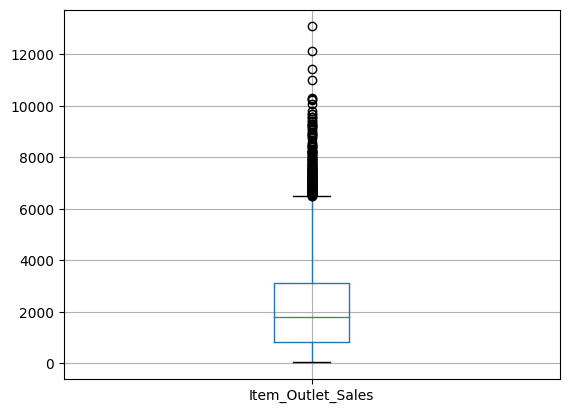

In [11]:


#check for outliers
sales_data.boxplot(column = ['Item_Outlet_Sales'])
plt.show()

In [12]:
#Remove outliers
def remove_outlier(col):
  sorted(col)
  Q1, Q3 = col.quantile([0.25,0.75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)

  return lower_range, upper_range
for _ in list(range(5)):
  lower, upper = remove_outlier(sales_data['Item_Outlet_Sales'])
  upper_array = np.where(sales_data['Item_Outlet_Sales']>=upper)[0]
  lower_array = np.where(sales_data['Item_Outlet_Sales']<=lower)[0]

  # Removing the outliers
  sales_data.drop(index=sales_data.index[upper_array], inplace=True)
  sales_data.drop(index=sales_data.index[lower_array], inplace=True)

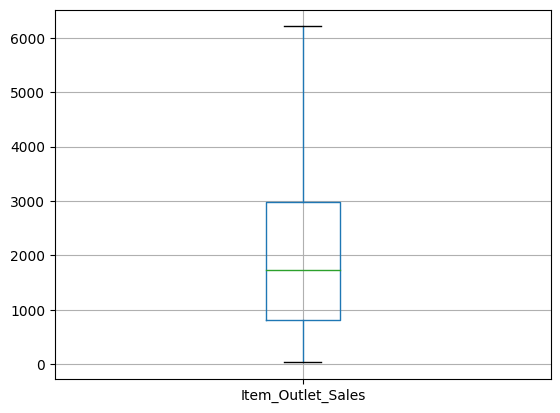

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,6943.000000,8290.000000,8290.000000,8290.000000,8290.000000
mean,12.855467,0.066374,138.728957,1997.969240,2034.951441
std,4.647076,0.051882,61.407454,8.304824,1474.938933
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.772500,0.027029,92.721850,1987.000000,806.450250
50%,12.600000,0.053904,140.615400,1999.000000,1733.743200
75%,16.850000,0.095374,182.986450,2004.000000,2972.131200
max,21.350000,0.328391,266.888400,2009.000000,6208.585000


In [13]:
#boxplot after removing outliers
sales_data.boxplot(column = ['Item_Outlet_Sales'])
plt.show()
sales_data.describe()

**6) Univariate Analysis**


<ipython-input-14-7de2b7ebaab2>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sales_data['Item_Weight'], shade=True)


<Axes: xlabel='Item_Weight', ylabel='Density'>

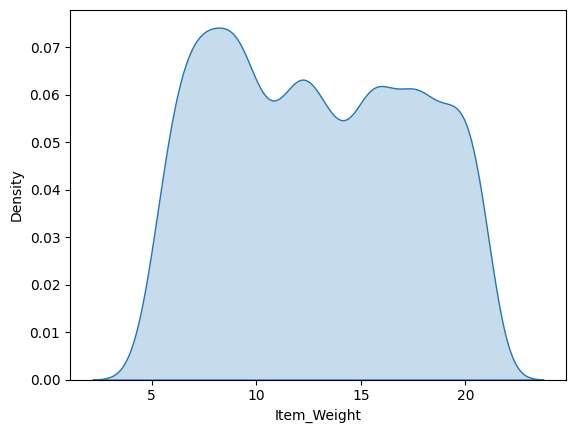

In [14]:

sns.kdeplot(data=sales_data['Item_Weight'], shade=True)

<ipython-input-15-84d14569520c>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sales_data['Item_MRP'], shade=True)


<Axes: xlabel='Item_MRP', ylabel='Density'>

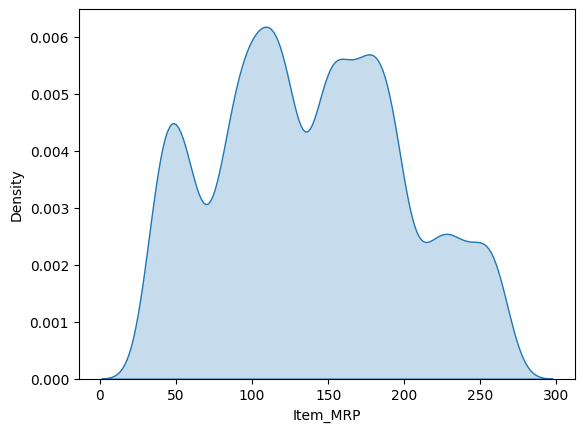

In [15]:
sns.kdeplot(data=sales_data['Item_MRP'], shade=True)


<ipython-input-16-4c52fd9e3117>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sales_data['Item_Visibility'], shade=True)


<Axes: xlabel='Item_Visibility', ylabel='Density'>

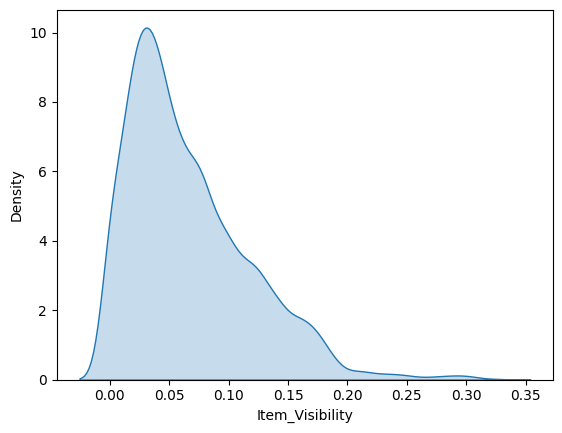

In [16]:
sns.kdeplot(data=sales_data['Item_Visibility'], shade=True)


<ipython-input-17-e97061233961>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=sales_data['Outlet_Establishment_Year'], shade=True)


<Axes: xlabel='Outlet_Establishment_Year', ylabel='Density'>

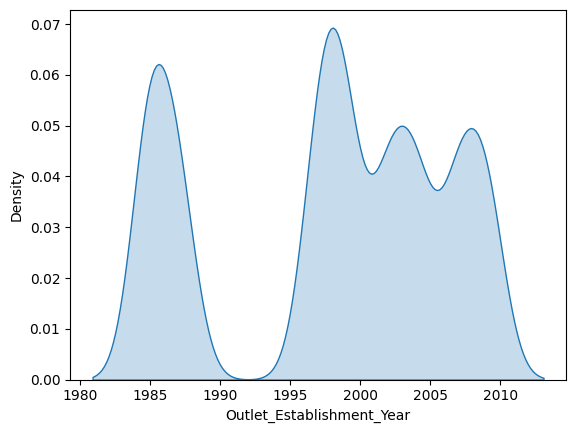

In [17]:
sns.kdeplot(data=sales_data['Outlet_Establishment_Year'], shade=True)


<Axes: >

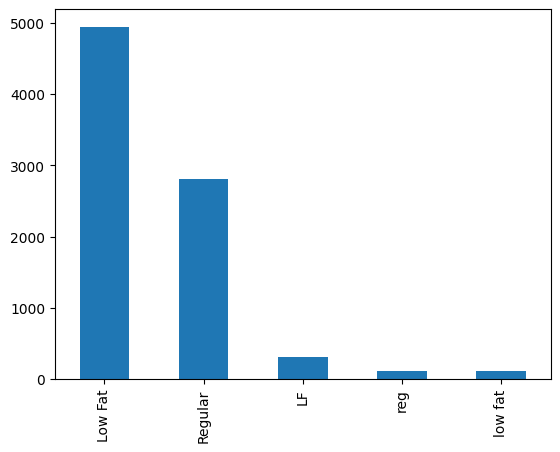

In [18]:
sales_data['Item_Fat_Content'].value_counts().plot(kind='bar')


* LF and low fat both are the same as Low Fat

* Also reg is the same as Regular


In [19]:
sales_data =  sales_data.replace(to_replace ="low fat",  value ="Low Fat")
sales_data =  sales_data.replace(to_replace ="LF",  value ="Low Fat")
sales_data =  sales_data.replace(to_replace ="reg",  value ="Regular")

<Axes: >

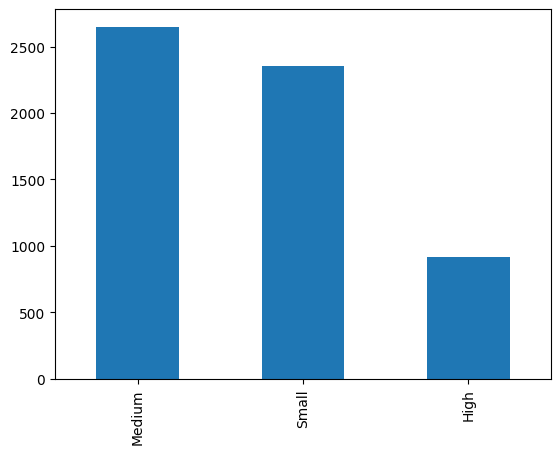

In [20]:
sales_data['Outlet_Size'].value_counts().plot(kind='bar')


<Axes: >

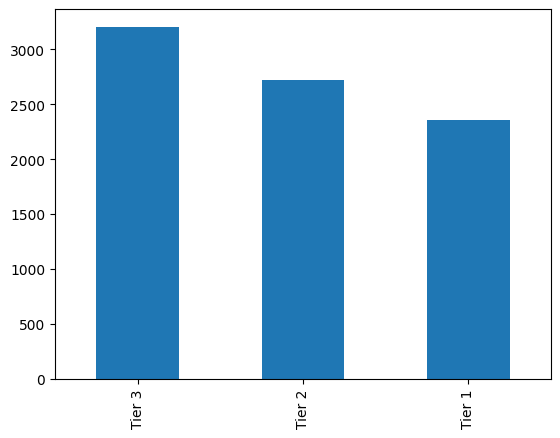

In [21]:
sales_data['Outlet_Location_Type'].value_counts().plot(kind='bar')


In [22]:
categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

**7) Bivariate Analysis**

<Axes: xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>

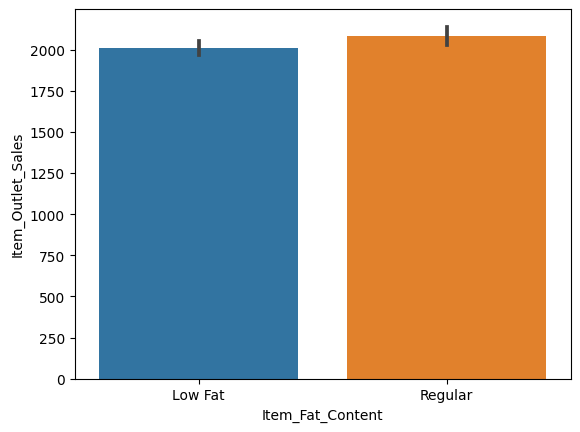

In [23]:
sns.barplot(x=sales_data['Item_Fat_Content'], y=sales_data['Item_Outlet_Sales'])


The number of 'Regular' product sales is slightly higher than that of 'Low Fat' so the hypothesis made about Healthiness of food is not correct

<Axes: xlabel='Item_Weight', ylabel='Item_Outlet_Sales'>

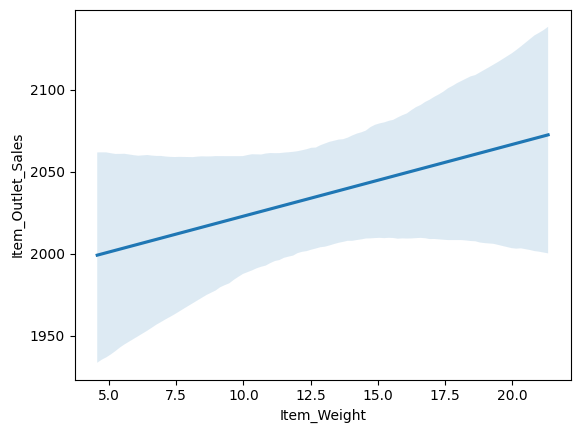

In [24]:
sns.regplot(x=sales_data['Item_Weight'], y=sales_data['Item_Outlet_Sales'],scatter = False)


There is a relation between Item Weight and Sales, sales increase by increasing the Item Weight, opposite to the hypothesis made

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

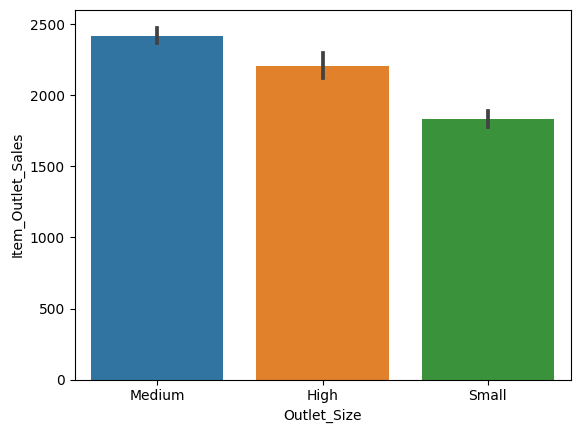

In [25]:
sns.barplot(x=sales_data['Outlet_Size'], y=sales_data['Item_Outlet_Sales'])


The medium sized outlet has the highest sales(failed hypothesis)

<Axes: xlabel='Item_MRP', ylabel='Item_Outlet_Sales'>

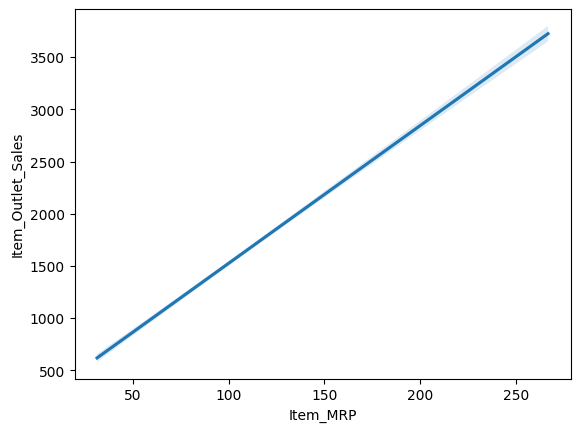

In [26]:
sns.regplot(x=sales_data['Item_MRP'], y=sales_data['Item_Outlet_Sales'],scatter = False)


The more expensive is the product, the more is its sales (correct hypothesis)

<Axes: xlabel='Item_Outlet_Sales', ylabel='Item_Type'>

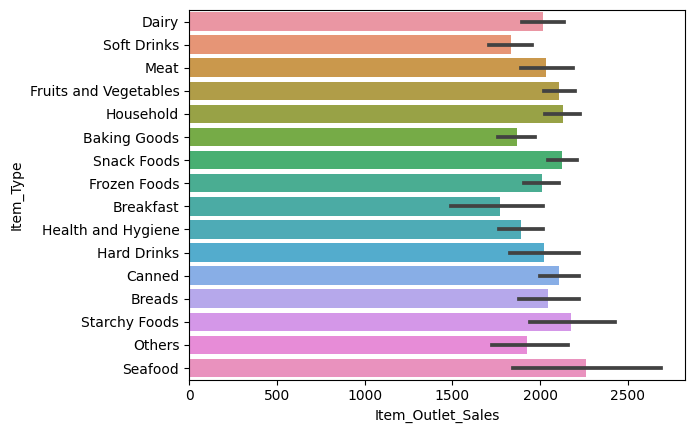

In [27]:

sns.barplot(x=sales_data['Item_Outlet_Sales'], y=sales_data['Item_Type'])


Daily used products as Breakfast, Bread and Dairy don't have the most sales(failed Hypothesis)

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Item_Outlet_Sales'>

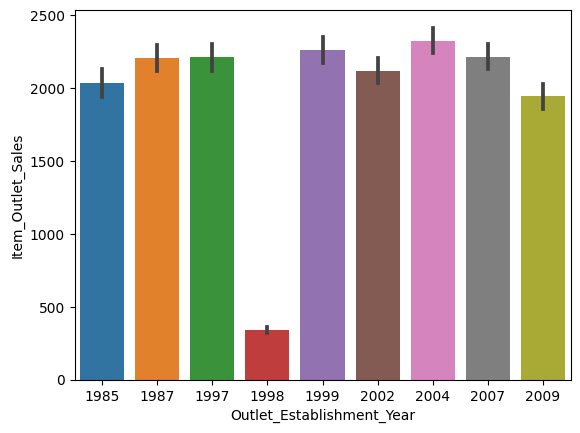

In [28]:
sns.barplot(y=sales_data['Item_Outlet_Sales'], x=sales_data['Outlet_Establishment_Year'])


Some Stores are old but have low sales (failed hypothesis)

**8) Missing Value Treatment**

In [29]:
#Check for columns with null values
print(sales_data.isnull().sum())


Item_Weight                  1347
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2373
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [30]:
#splitting data
y = sales_data['Item_Outlet_Sales']
X = sales_data.drop(['Item_Outlet_Sales'],axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [31]:
#Impute using the mean of the weights
weight_imputer = SimpleImputer(strategy = "mean")
X_train["Item_Weight"] = (pd.DataFrame(weight_imputer.fit_transform(X_train["Item_Weight"].to_frame())).values)
X_valid["Item_Weight"] = (pd.DataFrame(weight_imputer.transform(X_valid["Item_Weight"].to_frame())).values)
#Impute using the most frequent value of size
size_imputer = SimpleImputer(strategy = "most_frequent")
X_train["Outlet_Size"] = (pd.DataFrame(size_imputer.fit_transform(X_train["Outlet_Size"].to_frame())).values)
X_valid["Outlet_Size"] = (pd.DataFrame(size_imputer.transform(X_valid["Outlet_Size"].to_frame())).values)


print(X_train.isnull().sum())
print(X_valid.isnull().sum())

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


**9)Scaling**

**10)Encoding**

In [32]:
#Encoding Categorical Variables

ordinal_encoder1 = OrdinalEncoder()
X_train[['Item_Fat_Content','Outlet_Location_Type']] = ordinal_encoder1.fit_transform(X_train[['Item_Fat_Content','Outlet_Location_Type']])
X_valid[['Item_Fat_Content','Outlet_Location_Type']] = ordinal_encoder1.transform(X_valid[['Item_Fat_Content','Outlet_Location_Type']])
#Encoding Outlet Size
ordinal_encoder2 = OrdinalEncoder(categories = [['Small', 'Medium', 'High']])
X_train['Outlet_Size'] = ordinal_encoder2.fit_transform(X_train['Outlet_Size'].to_frame())
X_valid['Outlet_Size'] = ordinal_encoder2.transform(X_valid['Outlet_Size'].to_frame())


categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [33]:
#One Hot Encoding
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[['Item_Type','Outlet_Type']]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[['Item_Type','Outlet_Type']]))
OH_cols_names = OH_encoder.get_feature_names_out()
#set indices
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
#set column names
OH_cols_train.columns = OH_cols_names
OH_cols_valid.columns = OH_cols_names

X_train = X_train.drop(['Item_Type','Outlet_Type'],axis = 1)
X_valid = X_valid.drop(['Item_Type','Outlet_Type'],axis = 1)
#Concatenate the one hot encoded columns
X_train = pd.concat([X_train, OH_cols_train], axis=1)
X_valid = pd.concat([X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
X_train.columns = X_train.columns.astype(str)
X_valid.columns = X_valid.columns.astype(str)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**11) Modeling**

  1.  **Linear Regression Model**



In [34]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
predictions = linear_reg_model.predict(X_valid)
mean_absolute_error(y_valid, predictions)

755.5312870281391

2. **Random Forest Model**

In [35]:
#Modeling
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

scores = {}
for n in range(10,1000,50):
  model = RandomForestRegressor(n_estimators= n,random_state = 0)
  scores[n] = score_model(model,X_train,X_valid,y_train,y_valid)




In [36]:
best_n = min(scores,key = scores.get)
random_forest_model = RandomForestRegressor(n_estimators = best_n,random_state = 0)


In [37]:
score_model(random_forest_model,X_train,X_valid,y_train,y_valid)

721.9653901507841

3. **XGBoost Model**


In [38]:
xgb_scores = {}
for l in np.arange (0,1,0.01):
  xgb_model = XGBRegressor(n_estimators = 1000, learning_rate= l, early_stopping_rounds=5, random_state= 0)
  xgb_model.fit(X_train, y_train,  eval_set=[(X_valid, y_valid)], verbose=False)
  predictions = xgb_model.predict(X_valid)
  xgb_scores[l] = mean_absolute_error(y_valid, predictions)
min_learn = min(xgb_scores, key = xgb_scores.get)


xgb_model = XGBRegressor(n_estimators = 1000, learning_rate= min_learn, early_stopping_rounds=5, random_state= 0)
xgb_model.fit(X_train, y_train,  eval_set=[(X_valid, y_valid)], verbose=False)
predictions = xgb_model.predict(X_valid)
print(mean_absolute_error(y_valid, predictions))


687.0520651061863


XGB model produced the least mae




